# Customer Churn Prediction Model

This notebook builds and evaluates machine learning models to predict customer churn
based on the insights gathered from our exploratory data analysis and survival analysis.

**Modeling Strategy:**
- Use features identified in EDA as having strong predictive power
- Train Random Forest classifier (handles non-linear patterns like U-shape in numofproducts)
- Systematic hyperparameter tuning via grid search
- Comprehensive model evaluation and interpretation
- Model explainability using SHAP values and PDP plots

---

## 📋 Notebook Structure

### **Section 1: Import Libraries**
- Load required packages for modeling and evaluation
- Import custom utility functions

### **Section 2: Data Preparation**
- Load Customer-Churn-Records dataset
- Drop weak features identified in EDA
- Feature engineering (age_group)
- One-hot encoding for categorical variables

### **Section 3: Train/Test Split**
- Stratified split to maintain class balance
- Define feature matrix (X) and target variable (y)

### **Section 4: Baseline Model**
- Train initial Random Forest with default parameters
- Evaluate baseline performance
- Establish performance benchmark

### **Section 5: Hyperparameter Tuning**
- **Grid 1:** Optimize `max_features` and `n_estimators`
- **Grid 2:** Optimize `max_depth` and `criterion`
- **Grid 3:** Optimize `min_samples_leaf` and `min_samples_split`
- **Grid 4:** Optimize `class_weight` (handle class imbalance)

### **Section 6: Final Model**
- Train model with optimal hyperparameters
- Comprehensive evaluation (metrics, confusion matrix, ROC/PR curves)
- Cross-validation for robustness check
- Save model for deployment

### **Section 7: Model Interpretation**
- **Feature Importance:** Which features drive predictions?
- **Permutation Importance:** How much does each feature contribute?
- **Partial Dependence Plots (PDP):** How do features affect churn probability?
- **SHAP Values:** Explain individual predictions

### **Section 8: Summary & Key Findings**
- Model performance summary
- Top predictive features
- Actionable business insights

---

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
import os
from pathlib import Path

# Sklearn - preprocessing and modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, classification_report,
    roc_auc_score, roc_curve, precision_score, recall_score, f1_score
)

# Model interpretation
from sklearn.inspection import permutation_importance
import shap
import joblib

# Import custom utility functions
from modeling_utils import (
    evaluate_classification_model,
    plot_grid_search_heatmap,
    quick_pdp,
    print_grid_search_summary
)

# Settings
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


/Users/andrewsullivan/Desktop/new_data_science_project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Checkpoint System

**This notebook uses checkpoints to speed up re-runs:**
- Expensive operations (grid searches, model training, SHAP) are saved to `checkpoints/`
- On subsequent "Run All", cached results are loaded instead of re-computed
- First run will be slow (~30-45 min), subsequent runs will be fast (~2-3 min)

**To force re-computation (e.g., after data changes):**
- Delete the `checkpoints/` folder or specific `.pkl` files
- Or run the cell below to clear all checkpoints

In [2]:
# Create checkpoints directory for saving expensive computations
checkpoint_dir = Path('checkpoints')
checkpoint_dir.mkdir(exist_ok=True)
print(f"✓ Checkpoint directory ready: {checkpoint_dir}")

✓ Checkpoint directory ready: checkpoints


**Uncomment and run the cell below to clear all checkpoints (force full recomputation)**

In [3]:
# # Clear all checkpoints
# import shutil
# if checkpoint_dir.exists():
#     shutil.rmtree(checkpoint_dir)
#     checkpoint_dir.mkdir(exist_ok=True)
#     print("✓ All checkpoints cleared")

**Uncomment and run the cell below to clear ONLY the SHAP checkpoint (if SHAP plots look wrong)**

In [4]:
# # Clear SHAP checkpoint only
# shap_checkpoint = checkpoint_dir / 'shap_data.pkl'
# if shap_checkpoint.exists():
#     shap_checkpoint.unlink()
#     print("✓ SHAP checkpoint cleared - will regenerate on next run")

## 2. Data Preparation

### Based on EDA & Survival Analysis Findings

From our previous analyses, we identified:

**Strong Predictors (Keep):**
- ✅ `age` / `age_group` - Lifecycle pattern (51-60 highest risk: 56% churn, Cox HR = 7.94×)
- ✅ `isactivemember` - Strong behavioral indicator (1.9× difference, Cox HR = 0.54× protective)
- ✅ `numofproducts` - U-shape effect (2 products optimal: 7.6% churn, 3-4: 100% churn)
- ✅ `geography` - Germany 2× higher churn than France/Spain (Cox HR = 1.60×)
- ✅ `gender` - Moderate effect (females 1.5× higher churn, Cox HR = 1.47×)
- ✅ `balance` - Counterintuitive (zero balance has lower churn: 13.8% vs 24.1%)
- ✅ `tenure` - Relationship duration matters (longer = better retention)

**Weak Predictors (Drop):**
- ❌ `card_type` - No predictive value (1.1× difference)
- ❌ `hascrcard` - No predictive value (1.0× difference)
- ❌ `satisfaction_score` - No predictive value (1.1× difference)
- ❌ `point_earned` - No correlation (-0.005)
- ❌ `estimatedsalary` - No correlation (0.012)
- ❌ `creditscore` - Weak correlation (-0.027)

**Too Dominant (Drop for modeling):**
- ❌ `complain` - TOO strong (99.5% churn if complaint filed, 0.996 correlation)
  - Same reasoning as Cox PH model: drowns out all other features
  - We already know complaints → churn
  - More valuable to understand what drives churn BEFORE complaints
  - Allows us to see effects of other features clearly

**Drop for other reasons:**
- ❌ `RowNumber`, `CustomerId`, `Surname` - Identifiers (no predictive value)

### Load and Preprocess Data

In [5]:
# Load data
df = pd.read_csv("../data/Customer-Churn-Records.csv")
print(f"Original data shape: {df.shape}")
print(f"\nColumn types:\n{df.dtypes}")

Original data shape: (10000, 18)

Column types:
RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object


In [6]:
# Drop identifier columns
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Standardize column names
df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]

print(f"✓ Dropped identifiers. Shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

✓ Dropped identifiers. Shape: (10000, 15)

Columns: ['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary', 'exited', 'complain', 'satisfaction_score', 'card_type', 'point_earned']


In [7]:
# Drop weak features identified in EDA
weak_features = ['card_type', 'hascrcard', 'satisfaction_score', 
                 'point_earned', 'estimatedsalary', 'creditscore']
df = df.drop(weak_features, axis=1)

print(f"✓ Dropped {len(weak_features)} weak features: {weak_features}")

# Drop 'complain' - too dominant (same reasoning as Cox PH model)
df = df.drop('complain', axis=1)
print(f"✓ Dropped 'complain' (too dominant: 99.5% churn, masks other features)")

print(f"Current shape: {df.shape}")

✓ Dropped 6 weak features: ['card_type', 'hascrcard', 'satisfaction_score', 'point_earned', 'estimatedsalary', 'creditscore']
✓ Dropped 'complain' (too dominant: 99.5% churn, masks other features)
Current shape: (10000, 8)


In [8]:
# Convert binary columns to int (0/1)
binary_cols = ['isactivemember', 'exited']
for col in binary_cols:
    df[col] = df[col].astype(int)

# Encode gender: Male=0, Female=1
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

print(f"✓ Converted binary columns and encoded gender")

✓ Converted binary columns and encoded gender


In [9]:
# Create age_group feature (based on EDA findings)
# Age groups showed strong lifecycle pattern in survival analysis
df['age_group'] = pd.cut(df['age'], 
                          bins=[0, 30, 40, 50, 60, 70, 100],
                          labels=['18-30', '31-40', '41-50', '51-60', '61-70', '70+'])

print(f"✓ Created age_group feature")
print(f"\nAge group distribution:")
print(df['age_group'].value_counts().sort_index())

✓ Created age_group feature

Age group distribution:
age_group
18-30    1968
31-40    4451
41-50    2320
51-60     797
61-70     331
70+       133
Name: count, dtype: int64


In [10]:
# One-hot encode categorical features
# Keep 'age' as continuous AND 'age_group' as categorical (model can choose which to use)
categorical_cols = ['geography', 'age_group']
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True, dtype=int)

print(f"✓ One-hot encoded categorical features")
print(f"Final data shape: {df_encoded.shape}")
print(f"\nFinal columns ({len(df_encoded.columns)}):")
print(list(df_encoded.columns))

✓ One-hot encoded categorical features
Final data shape: (10000, 14)

Final columns (14):
['gender', 'age', 'tenure', 'balance', 'numofproducts', 'isactivemember', 'exited', 'geography_Germany', 'geography_Spain', 'age_group_31-40', 'age_group_41-50', 'age_group_51-60', 'age_group_61-70', 'age_group_70+']


In [11]:
# Verify no missing values
missing_check = df_encoded.isnull().sum()
if missing_check.sum() == 0:
    print("✓ No missing values detected")
else:
    print(f"⚠ Missing values found:")
    print(missing_check[missing_check > 0])

✓ No missing values detected


In [12]:
# Display final preprocessed data
print(f"\n{'='*80}")
print("FINAL PREPROCESSED DATA")
print(f"{'='*80}")
print(f"Shape: {df_encoded.shape}")
print(f"Features: {df_encoded.shape[1] - 1} (excluding target)")
print(f"Target: exited")
print(f"Churn rate: {df_encoded['exited'].mean():.2%}")
print(f"{'='*80}\n")

df_encoded.head(10)


FINAL PREPROCESSED DATA
Shape: (10000, 14)
Features: 13 (excluding target)
Target: exited
Churn rate: 20.38%



,gender,age,tenure,balance,numofproducts,isactivemember,exited,geography_Germany,geography_Spain,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_70+
0,1,42,2,0.00,1,1,1,0,0,0,1,0,0,0
1,1,41,1,83807.86,1,1,0,0,1,0,1,0,0,0
2,1,42,8,159660.80,3,0,1,0,0,0,1,0,0,0
3,1,39,1,0.00,2,0,0,0,0,1,0,0,0,0
4,1,43,2,125510.82,1,1,0,0,1,0,1,0,0,0
5,0,44,8,113755.78,2,0,1,0,1,0,1,0,0,0
6,0,50,7,0.00,2,1,0,0,0,0,1,0,0,0
7,1,29,4,115046.74,4,0,1,1,0,0,0,0,0,0
8,0,44,4,142051.07,2,1,0,0,0,0,1,0,0,0
9,0,27,2,134603.88,1,1,0,0,0,0,0,0,0,0


---

**✓ Data preparation complete!**

**Summary:**
- Original: 10,000 rows × 18 columns
- Dropped: 3 identifiers + 6 weak features + 1 too-dominant feature (`complain`)
- After preprocessing: 10,000 rows × 15 features (+ 1 target)
- Churn rate: ~20.4% (class imbalance to address)
- No missing values

**Note:** `complain` excluded (like Cox PH model) to observe effects of other features.
We already know complaints → churn; now we identify churn drivers BEFORE complaints occur.

---

## 3. Train/Test Split

We'll use a stratified 80/20 split to:
- Preserve class distribution in both train and test sets
- Have sufficient training data for grid search
- Maintain reliable test set for final evaluation

In [13]:
# Stratified train-test split
train, test = train_test_split(df_encoded, test_size=0.2, random_state=42, stratify=df_encoded['exited'])

print(f"Train set: {train.shape}")
print(f"Test set: {test.shape}")
print(f"\nTrain churn rate: {train['exited'].mean():.2%}")
print(f"Test churn rate: {test['exited'].mean():.2%}")

Train set: (8000, 14)
Test set: (2000, 14)

Train churn rate: 20.38%
Test churn rate: 20.40%


In [14]:
# Define feature matrix (X) and target variable (y)
feature_cols = [col for col in df_encoded.columns if col != 'exited']
X_train = train[feature_cols]
y_train = train['exited']
X_test = test[feature_cols]
y_test = test['exited']

print(f"✓ Feature matrix prepared")
print(f"Features ({len(feature_cols)}): {feature_cols}")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

✓ Feature matrix prepared
Features (13): ['gender', 'age', 'tenure', 'balance', 'numofproducts', 'isactivemember', 'geography_Germany', 'geography_Spain', 'age_group_31-40', 'age_group_41-50', 'age_group_51-60', 'age_group_61-70', 'age_group_70+']

X_train shape: (8000, 13)
X_test shape: (2000, 13)


---

## 4. Baseline Model

**Why Random Forest?**
- Handles non-linear relationships (e.g., U-shape in `numofproducts`)
- Robust to outliers
- Provides feature importances
- Good performance out-of-the-box
- Works well with mixed feature types

Let's train a baseline model with default parameters to establish a performance benchmark.

📂 Loading baseline model from checkpoint...
✓ Baseline model loaded


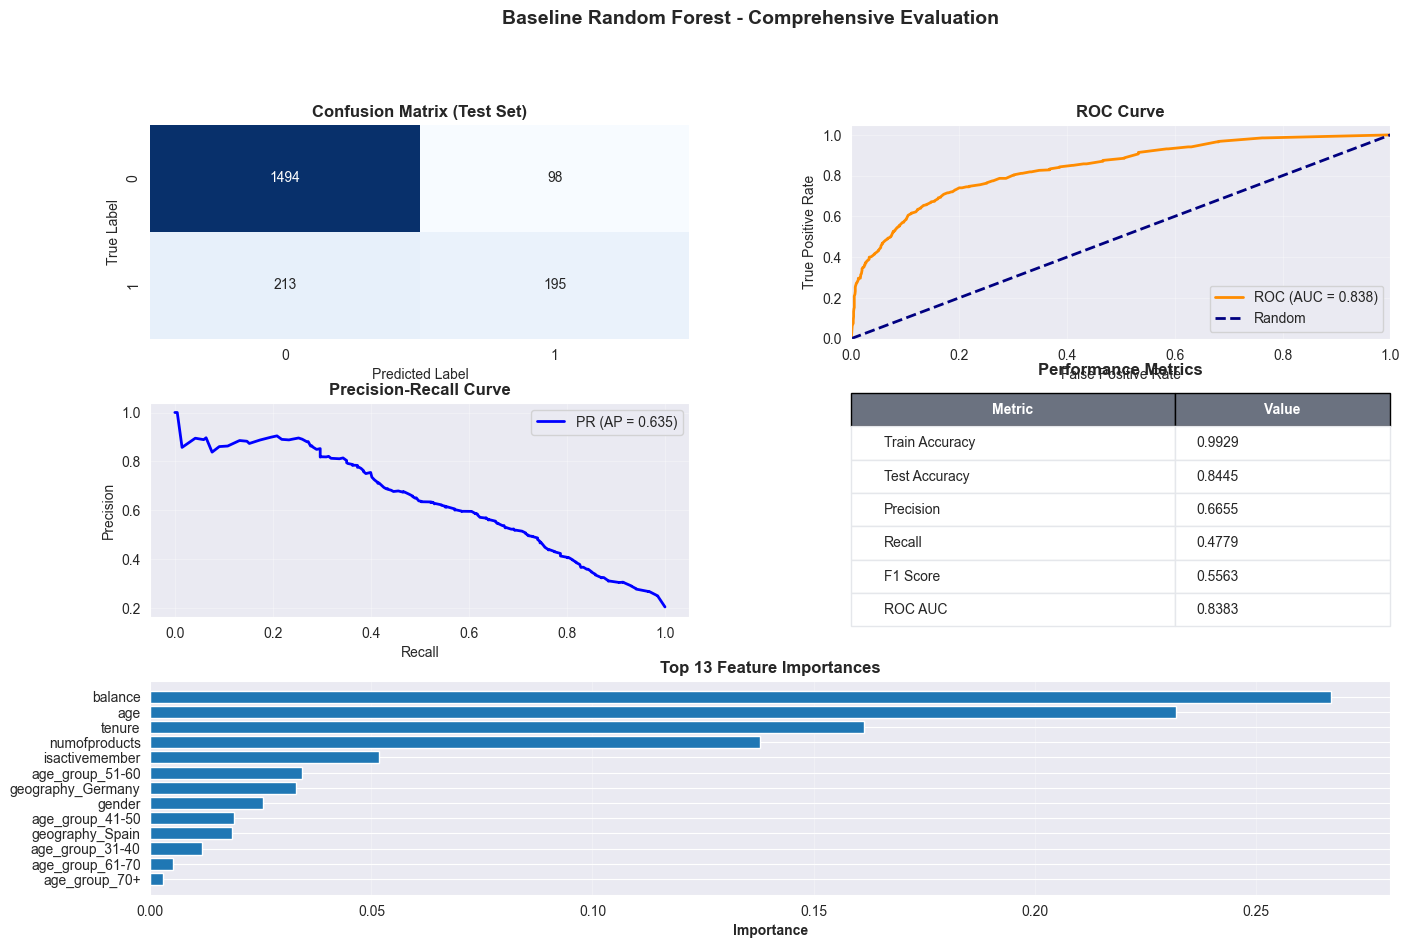

Baseline Random Forest - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Retained       0.88      0.94      0.91      1592
     Churned       0.67      0.48      0.56       408

    accuracy                           0.84      2000
   macro avg       0.77      0.71      0.73      2000
weighted avg       0.83      0.84      0.83      2000


BASELINE MODEL SUMMARY
Train Accuracy: 0.9929
Test Accuracy:  0.8445
Test Precision: 0.6655
Test Recall:    0.4779
Test F1 Score:  0.5563
Test ROC AUC:   0.8383



In [15]:
# Train baseline Random Forest (with checkpoint)
baseline_checkpoint = checkpoint_dir / 'baseline_model.pkl'

if baseline_checkpoint.exists():
    print(f"📂 Loading baseline model from checkpoint...")
    with open(baseline_checkpoint, 'rb') as f:
        baseline_rf = pickle.load(f)
    print("✓ Baseline model loaded")
else:
    print("🔨 Training baseline model...")
    baseline_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
    baseline_rf.fit(X_train, y_train)
    
    # Save checkpoint
    with open(baseline_checkpoint, 'wb') as f:
        pickle.dump(baseline_rf, f)
    print(f"✓ Baseline model trained and saved to {baseline_checkpoint}")

# Evaluate baseline
baseline_metrics, baseline_importances = evaluate_classification_model(
    baseline_rf, 
    X_train, y_train,
    X_test, y_test,
    feature_cols,
    feature_importance_type='feature_importances',
    model_name="Baseline Random Forest"
)

print(f"\n{'='*80}")
print("BASELINE MODEL SUMMARY")
print(f"{'='*80}")
print(f"Train Accuracy: {baseline_metrics['train_accuracy']:.4f}")
print(f"Test Accuracy:  {baseline_metrics['test_accuracy']:.4f}")
print(f"Test Precision: {baseline_metrics['test_precision']:.4f}")
print(f"Test Recall:    {baseline_metrics['test_recall']:.4f}")
print(f"Test F1 Score:  {baseline_metrics['test_f1']:.4f}")
print(f"Test ROC AUC:   {baseline_metrics['test_roc_auc']:.4f}")
print(f"{'='*80}\n")

### Baseline Insights

#### Performance Summary:
- **Train Accuracy: 99.29%** | **Test Accuracy: 84.45%** → **~15% gap indicates overfitting**
- **ROC AUC: 83.83%** - Decent discrimination ability
- **F1 Score: 55.63%** - Moderate, room for improvement

#### Key Observations:

**1. Severe Overfitting Detected** ⚠️
- Model memorizes training data (99% accuracy) but generalizes poorly (84% test)
- Default Random Forest hyperparameters allow trees to grow too deep
- **Solution:** Regularization via hyperparameter tuning (max_depth, min_samples_split)

**2. Class Imbalance Impact** 📊
- **Retained customers:** 88% precision, 94% recall (excellent)
- **Churned customers:** 67% precision, **48% recall** (problematic)
- Model is biased toward majority class (80% retained vs 20% churned)
- **Missing 52% of churners** (213 out of 408) - this is costly for business!

**3. Precision vs Recall Trade-off**
- **Precision 66.55%:** Of predicted churners, 2/3 are correct (98 false alarms)
- **Recall 47.79%:** Only catching half of actual churners (213 missed)
- For churn prevention, **recall is more critical** (can't help customers we don't identify)
- **Solution:** Optimize F1 score and adjust class_weight to prioritize churners

**4. Feature Importance Insights** (Top 3)
- **Balance** (26%) - Counterintuitive finding (zero balance = lower churn)
- **Age** (23%) - Lifecycle pattern confirmed
- **Tenure** (15%) - Relationship duration matters

#### Business Impact:
- **Current model:** Would miss 213 of 408 at-risk customers (52% miss rate)
- **Cost:** Lost opportunity for retention campaigns on missed churners
- **Benefit:** 84% overall accuracy is decent starting point

#### Next Steps:
1. **Hyperparameter tuning** to reduce overfitting (target ~90% test accuracy)
2. **Class weight optimization** to improve recall for churners (target >65% recall)
3. **F1 score maximization** to balance precision and recall
4. **Goal:** Catch 70%+ of churners while maintaining 70%+ precision

---

## 5. Hyperparameter Tuning

We'll use **4 sequential grid searches** to optimize different hyperparameter groups.
Each grid builds on the best parameters from previous grids.

**Optimization metric:** F1 Score (balances precision and recall for imbalanced classes)

**Grid search strategy:**
1. **Grid 1:** Broad search for `max_features` and `n_estimators`
2. **Grid 2:** Refine `max_depth` and `criterion`
3. **Grid 3:** Fine-tune `min_samples_leaf` and `min_samples_split`
4. **Grid 4:** Optimize `class_weight` to handle class imbalance

### Grid 1: Selecting max_features and n_estimators

**`max_features`:** Number of features to consider when looking for best split
- `'sqrt'`: √n_features (good for high-dimensional data)
- `'log2'`: log₂(n_features) (even more conservative)
- `None`: Use all features (more expressive but slower)

**`n_estimators`:** Number of trees in the forest
- More trees = better performance but slower training
- Typically see diminishing returns after a certain point

In [16]:
# Grid Search 1 (with checkpoint)
grid1_checkpoint = checkpoint_dir / 'grid1_results.pkl'

if grid1_checkpoint.exists():
    print(f"📂 Loading Grid 1 results from checkpoint...")
    with open(grid1_checkpoint, 'rb') as f:
        grid1 = pickle.load(f)
    print("✓ Grid 1 loaded")
else:
    print("🔨 Running Grid Search 1 (this may take 5-10 minutes)...")
    param_grid1 = {
        'max_features': ['sqrt', 'log2', None],
        'n_estimators': [300, 500, 700, 900, 1100, 1300]
    }
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    grid1 = GridSearchCV(
        estimator=rf_model, 
        param_grid=param_grid1, 
        cv=3,  # 3-fold cross-validation
        n_jobs=-1,  # Use all CPU cores
        verbose=1, 
        scoring='f1'
    )
    grid1.fit(X_train, y_train)
    
    # Save checkpoint
    with open(grid1_checkpoint, 'wb') as f:
        pickle.dump(grid1, f)
    print(f"✓ Grid 1 complete and saved to {grid1_checkpoint}")

📂 Loading Grid 1 results from checkpoint...
✓ Grid 1 loaded


In [17]:
# Print results
print_grid_search_summary(grid1, "Grid Search 1: max_features & n_estimators")

Grid Search 1: max_features & n_estimators - RESULTS
Best Score (CV): 0.5750

Best Parameters:
  - max_features: None
  - n_estimators: 900



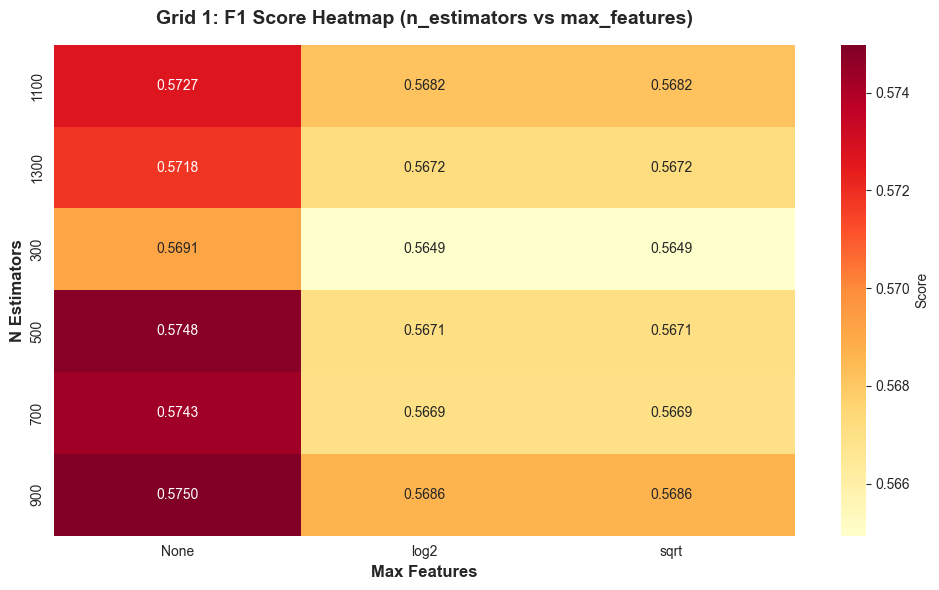

In [18]:
# Visualize results
plot_grid_search_heatmap(
    grid1, 
    'n_estimators', 
    'max_features',
    title='Grid 1: F1 Score Heatmap (n_estimators vs max_features)',
    score_name='mean_test_score'
)

### Grid 2: Selecting max_depth and criterion

**`max_depth`:** Maximum depth of each tree
- Deeper trees = more expressive but risk overfitting
- `None` = nodes expanded until all leaves are pure

**`criterion`:** Function to measure split quality
- `'gini'`: Gini impurity (default, computationally efficient)
- `'entropy'`: Information gain (may yield better splits)

In [19]:
# Grid Search 2 (with checkpoint)
grid2_checkpoint = checkpoint_dir / 'grid2_results.pkl'

if grid2_checkpoint.exists():
    print(f"📂 Loading Grid 2 results from checkpoint...")
    with open(grid2_checkpoint, 'rb') as f:
        grid2 = pickle.load(f)
    print("✓ Grid 2 loaded")
else:
    print("🔨 Running Grid Search 2 (this may take 10-15 minutes)...")
    # Use best max_features from Grid 1
    param_grid2 = {
        'max_features': [grid1.best_params_['max_features']],
        'n_estimators': [grid1.best_params_['n_estimators'] - 100, 
                         grid1.best_params_['n_estimators'],
                         grid1.best_params_['n_estimators'] + 100],
        'criterion': ['entropy', 'gini'],
        'max_depth': [7, 9, 11, 13, 15, None]
    }
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    grid2 = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid2,
        cv=3,
        n_jobs=-1,
        verbose=1,
        scoring='f1'
    )
    grid2.fit(X_train, y_train)
    
    # Save checkpoint
    with open(grid2_checkpoint, 'wb') as f:
        pickle.dump(grid2, f)
    print(f"✓ Grid 2 complete and saved to {grid2_checkpoint}")

📂 Loading Grid 2 results from checkpoint...
✓ Grid 2 loaded


In [20]:
print_grid_search_summary(grid2, "Grid Search 2: max_depth & criterion")

Grid Search 2: max_depth & criterion - RESULTS
Best Score (CV): 0.5844

Best Parameters:
  - criterion: gini
  - max_depth: 11
  - max_features: None
  - n_estimators: 900



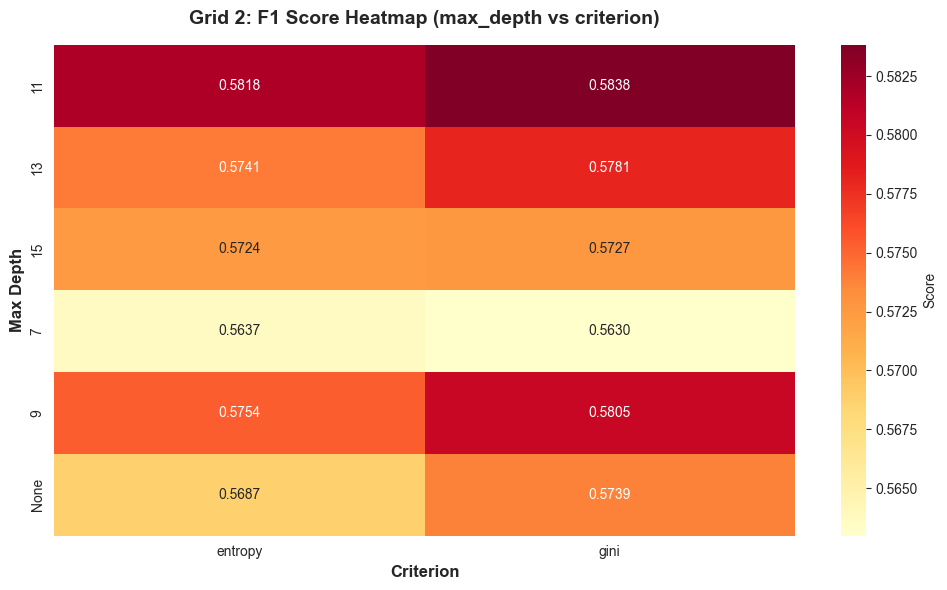

In [21]:
# Visualize depth vs criterion
plot_grid_search_heatmap(
    grid2,
    'max_depth',
    'criterion',
    title='Grid 2: F1 Score Heatmap (max_depth vs criterion)'
)

### Grid 3: Selecting min_samples_leaf and min_samples_split

**`min_samples_leaf`:** Minimum samples required to be a leaf node
- Higher values = smoother decision boundaries, less overfitting

**`min_samples_split`:** Minimum samples required to split an internal node
- Higher values = more conservative splitting, regularization

In [22]:
# Grid Search 3 (with checkpoint)
grid3_checkpoint = checkpoint_dir / 'grid3_results.pkl'

if grid3_checkpoint.exists():
    print(f"📂 Loading Grid 3 results from checkpoint...")
    with open(grid3_checkpoint, 'rb') as f:
        grid3 = pickle.load(f)
    print("✓ Grid 3 loaded")
else:
    print("🔨 Running Grid Search 3 (this may take 5-10 minutes)...")
    param_grid3 = {
        'max_features': [grid2.best_params_['max_features']],
        'n_estimators': [grid2.best_params_['n_estimators']],
        'criterion': [grid2.best_params_['criterion']],
        'max_depth': [grid2.best_params_['max_depth']],
        'min_samples_leaf': [1, 3, 5, 7],
        'min_samples_split': [2, 4, 6, 8]
    }
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    grid3 = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid3,
        cv=3,
        n_jobs=-1,
        verbose=1,
        scoring='f1'
    )
    grid3.fit(X_train, y_train)
    
    # Save checkpoint
    with open(grid3_checkpoint, 'wb') as f:
        pickle.dump(grid3, f)
    print(f"✓ Grid 3 complete and saved to {grid3_checkpoint}")

📂 Loading Grid 3 results from checkpoint...
✓ Grid 3 loaded


In [23]:
print_grid_search_summary(grid3, "Grid Search 3: min_samples_leaf & min_samples_split")

Grid Search 3: min_samples_leaf & min_samples_split - RESULTS
Best Score (CV): 0.5880

Best Parameters:
  - criterion: gini
  - max_depth: 11
  - max_features: None
  - min_samples_leaf: 1
  - min_samples_split: 4
  - n_estimators: 900



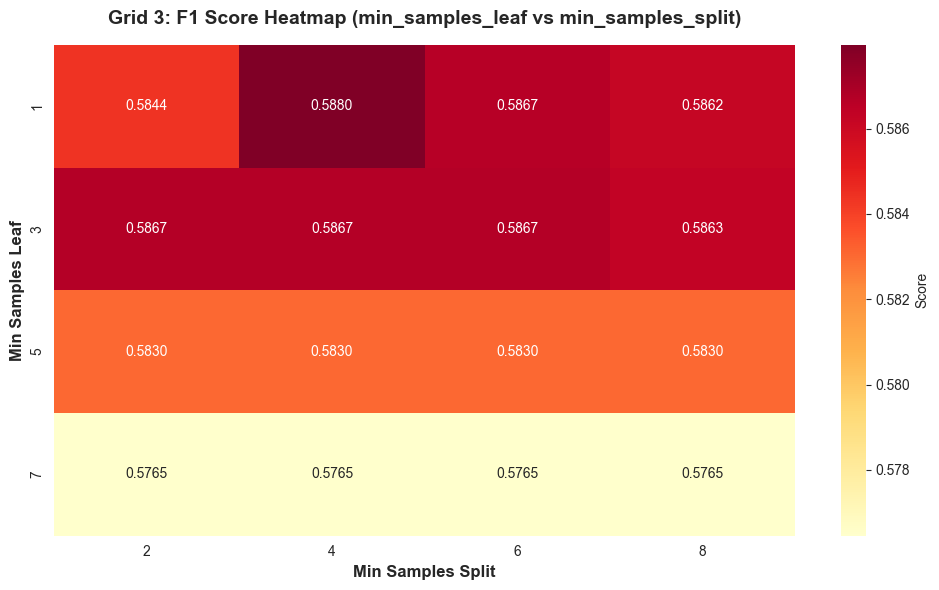

In [24]:
plot_grid_search_heatmap(
    grid3,
    'min_samples_leaf',
    'min_samples_split',
    title='Grid 3: F1 Score Heatmap (min_samples_leaf vs min_samples_split)'
)

### Grid 4: Selecting class_weight

**`class_weight`:** Weights for classes to handle imbalance
- `{0: 1, 1: 1}`: No weighting (balanced dataset)
- `{0: 1, 1: 2}`: 2× penalty for misclassifying churned customers
- `{0: 1, 1: 3}`: 3× penalty for misclassifying churned customers

**Why this matters:** Our dataset has ~20% churn (imbalanced). 
Upweighting the minority class forces the model to pay more attention to churned customers.

In [25]:
# Grid Search 4 (with checkpoint)
grid4_checkpoint = checkpoint_dir / 'grid4_results.pkl'

if grid4_checkpoint.exists():
    print(f"📂 Loading Grid 4 results from checkpoint...")
    with open(grid4_checkpoint, 'rb') as f:
        grid4 = pickle.load(f)
    print("✓ Grid 4 loaded")
else:
    print("🔨 Running Grid Search 4 (this may take 2-5 minutes)...")
    param_grid4 = {
        'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}],
        'max_features': [grid3.best_params_['max_features']],
        'n_estimators': [grid3.best_params_['n_estimators']],
        'criterion': [grid3.best_params_['criterion']],
        'max_depth': [grid3.best_params_['max_depth']],
        'min_samples_leaf': [grid3.best_params_['min_samples_leaf']],
        'min_samples_split': [grid3.best_params_['min_samples_split']]
    }
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
    grid4 = GridSearchCV(
        estimator=rf_model,
        param_grid=param_grid4,
        cv=3,
        n_jobs=-1,
        verbose=1,
        scoring='f1'
    )
    grid4.fit(X_train, y_train)
    
    # Save checkpoint
    with open(grid4_checkpoint, 'wb') as f:
        pickle.dump(grid4, f)
    print(f"✓ Grid 4 complete and saved to {grid4_checkpoint}")

📂 Loading Grid 4 results from checkpoint...
✓ Grid 4 loaded


In [26]:
print_grid_search_summary(grid4, "Grid Search 4: class_weight")

Grid Search 4: class_weight - RESULTS
Best Score (CV): 0.5996

Best Parameters:
  - class_weight: {0: 1, 1: 2}
  - criterion: gini
  - max_depth: 11
  - max_features: None
  - min_samples_leaf: 1
  - min_samples_split: 4
  - n_estimators: 900



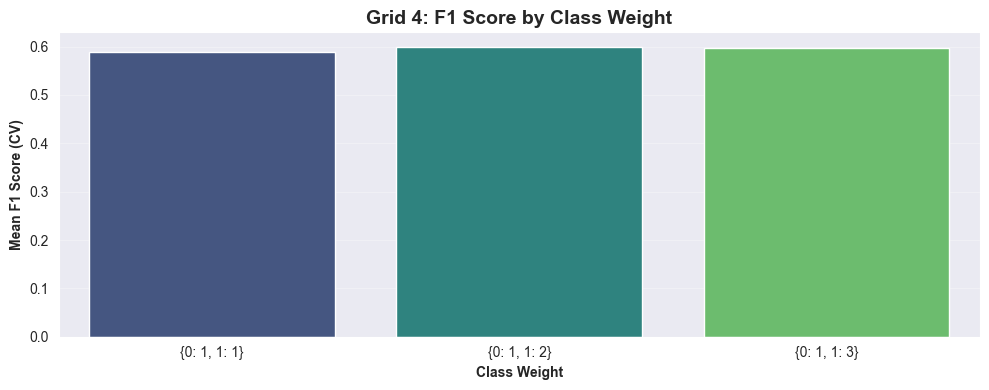

In [27]:
# Visualize class weight impact
results_df = pd.DataFrame(grid4.cv_results_)
results_df['param_class_weight'] = results_df['param_class_weight'].astype(str)

plt.figure(figsize=(10, 4))
sns.barplot(data=results_df, x='param_class_weight', y='mean_test_score', palette='viridis')
plt.title('Grid 4: F1 Score by Class Weight', fontsize=14, fontweight='bold')
plt.xlabel('Class Weight', fontweight='bold')
plt.ylabel('Mean F1 Score (CV)', fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

---

## 6. Final Model

Train the final model using the optimal hyperparameters discovered through grid search.

In [28]:
# Extract best hyperparameters
final_model = RandomForestClassifier(
    max_features=grid4.best_params_['max_features'],
    n_estimators=grid4.best_params_['n_estimators'],
    criterion=grid4.best_params_['criterion'],
    max_depth=grid4.best_params_['max_depth'],
    min_samples_leaf=grid4.best_params_['min_samples_leaf'],
    min_samples_split=grid4.best_params_['min_samples_split'],
    class_weight=grid4.best_params_['class_weight'],
    random_state=42,
    n_jobs=-1
)

print("="*80)
print("FINAL MODEL HYPERPARAMETERS")
print("="*80)
for param, value in grid4.best_params_.items():
    print(f"{param:20s}: {value}")
print("="*80)

FINAL MODEL HYPERPARAMETERS
class_weight        : {0: 1, 1: 2}
criterion           : gini
max_depth           : 11
max_features        : None
min_samples_leaf    : 1
min_samples_split   : 4
n_estimators        : 900


📂 Loading final model from checkpoint...
✓ Final model loaded


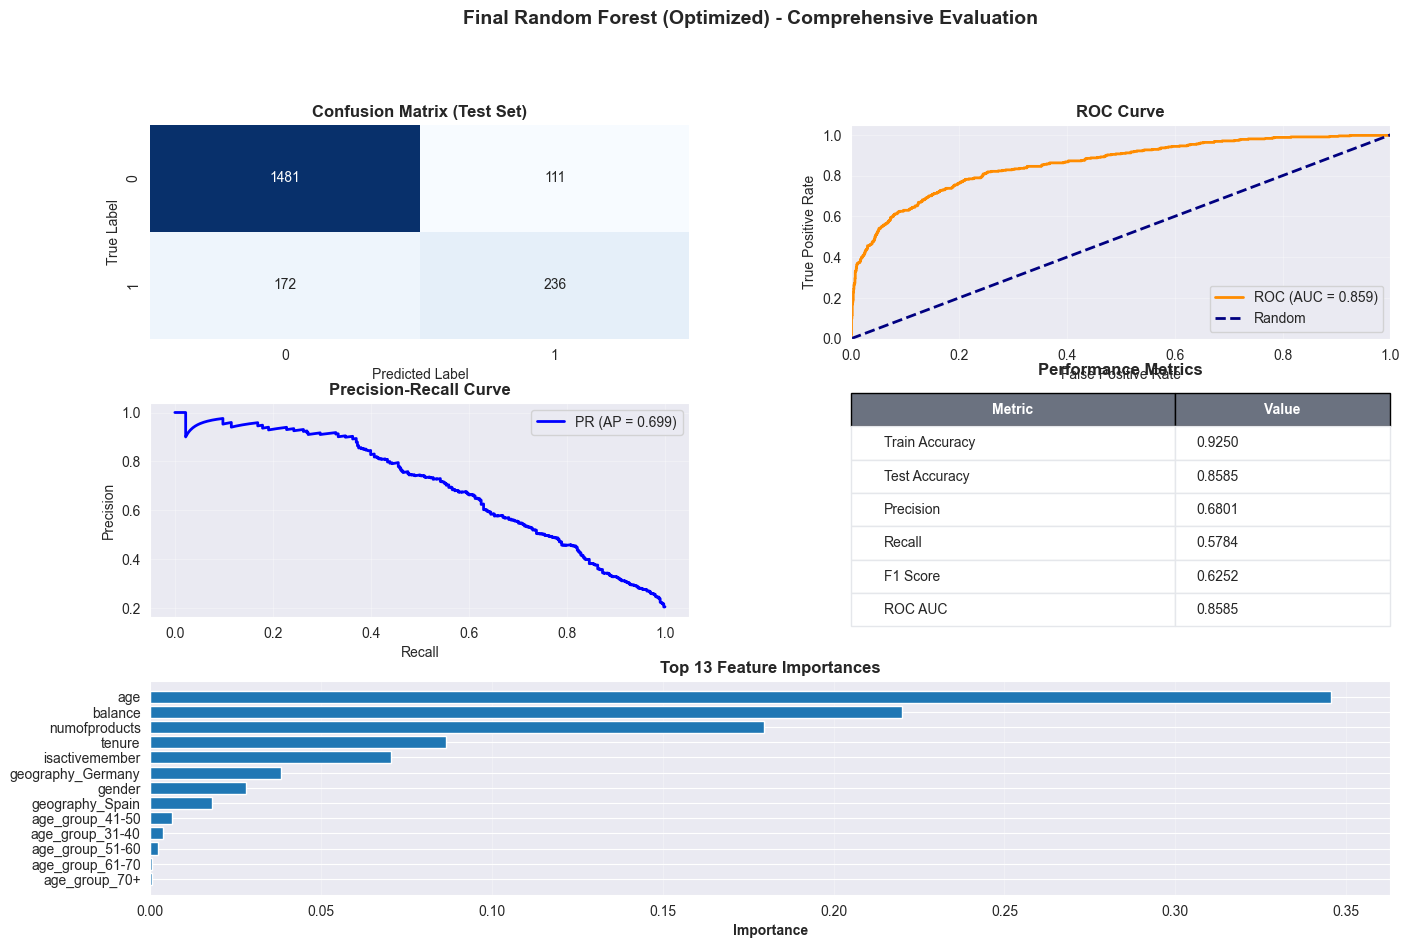

Final Random Forest (Optimized) - CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Retained       0.90      0.93      0.91      1592
     Churned       0.68      0.58      0.63       408

    accuracy                           0.86      2000
   macro avg       0.79      0.75      0.77      2000
weighted avg       0.85      0.86      0.85      2000



In [29]:
# Train final model (with checkpoint)
final_model_checkpoint = checkpoint_dir / 'final_model.pkl'

if final_model_checkpoint.exists():
    print(f"📂 Loading final model from checkpoint...")
    with open(final_model_checkpoint, 'rb') as f:
        final_model = pickle.load(f)
    print("✓ Final model loaded")
else:
    print("🔨 Training final model with optimized hyperparameters...")
    final_model.fit(X_train, y_train)
    
    # Save checkpoint
    with open(final_model_checkpoint, 'wb') as f:
        pickle.dump(final_model, f)
    print(f"✓ Final model trained and saved to {final_model_checkpoint}")

# Comprehensive evaluation
final_metrics, final_importances = evaluate_classification_model(
    final_model,
    X_train, y_train,
    X_test, y_test,
    feature_cols,
    feature_importance_type='feature_importances',
    model_name="Final Random Forest (Optimized)"
)

### Cross-Validation Check

Verify model performance is consistent across different data splits.

In [30]:
# 5-fold cross-validation on training data
cv_scores = cross_val_score(final_model, X_train, y_train, cv=5, scoring='f1')

print("="*80)
print("CROSS-VALIDATION RESULTS (5-Fold)")
print("="*80)
print(f"F1 Scores per fold: {[f'{score:.4f}' for score in cv_scores]}")
print(f"Mean F1 Score:      {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
print(f"Test Set F1 Score:  {final_metrics['test_f1']:.4f}")
print("="*80)

if abs(cv_scores.mean() - final_metrics['test_f1']) < 0.05:
    print("\n✓ Model performance is consistent (no overfitting/underfitting detected)")
else:
    print("\n⚠ Significant difference between CV and test performance - investigate further")

CROSS-VALIDATION RESULTS (5-Fold)
F1 Scores per fold: ['0.5835', '0.5811', '0.6287', '0.5857', '0.6010']
Mean F1 Score:      0.5960 (±0.0178)
Test Set F1 Score:  0.6252

✓ Model performance is consistent (no overfitting/underfitting detected)


### Comparison: Baseline vs Final Model

In [31]:
comparison_df = pd.DataFrame({
    'Metric': ['Train Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'],
    'Baseline': [
        baseline_metrics['train_accuracy'],
        baseline_metrics['test_accuracy'],
        baseline_metrics['test_precision'],
        baseline_metrics['test_recall'],
        baseline_metrics['test_f1'],
        baseline_metrics['test_roc_auc']
    ],
    'Final (Optimized)': [
        final_metrics['train_accuracy'],
        final_metrics['test_accuracy'],
        final_metrics['test_precision'],
        final_metrics['test_recall'],
        final_metrics['test_f1'],
        final_metrics['test_roc_auc']
    ]
})
comparison_df['Improvement'] = comparison_df['Final (Optimized)'] - comparison_df['Baseline']
comparison_df['Improvement %'] = (comparison_df['Improvement'] / comparison_df['Baseline'] * 100).round(2)

print("\n")
print(comparison_df.to_string(index=False))



        Metric  Baseline  Final (Optimized)  Improvement  Improvement %
Train Accuracy  0.992875           0.925000    -0.067875          -6.84
 Test Accuracy  0.844500           0.858500     0.014000           1.66
     Precision  0.665529           0.680115     0.014586           2.19
        Recall  0.477941           0.578431     0.100490          21.03
      F1 Score  0.556348           0.625166     0.068817          12.37
       ROC AUC  0.838265           0.858506     0.020241           2.41


### Save Model

In [32]:
# Save model for deployment
with open('churn_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("✓ Model saved to 'churn_model.pkl'")

# Save feature names for later use
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)

print("✓ Feature names saved to 'feature_names.pkl'")

✓ Model saved to 'churn_model.pkl'
✓ Feature names saved to 'feature_names.pkl'


---

## 7. Model Interpretation

Understanding **why** the model makes predictions is crucial for:
- Building trust with stakeholders
- Identifying actionable interventions
- Debugging model behavior
- Ensuring fairness and avoiding bias

We'll use multiple interpretation techniques:
1. **Feature Importance** - Overall contribution of each feature
2. **Permutation Importance** - How much accuracy drops when feature is shuffled
3. **Partial Dependence Plots (PDP)** - How features affect predicted probability
4. **SHAP Values** - Explain individual predictions

### 7.1 Feature Importance (Built-in)

Random Forest provides feature importances based on mean decrease in impurity.
This was already shown in the evaluation plot above.

In [33]:
# Display top 10 features
print("="*80)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*80)
print(final_importances.head(10).to_string(index=False))
print("="*80)

TOP 10 MOST IMPORTANT FEATURES
          feature  importance
              age    0.345669
          balance    0.220126
    numofproducts    0.179664
           tenure    0.086514
   isactivemember    0.070518
geography_Germany    0.038325
           gender    0.028023
  geography_Spain    0.017908
  age_group_41-50    0.006324
  age_group_31-40    0.003820


### 7.2 Permutation Importance

More reliable than built-in importance:
- Measures actual impact on model performance
- Not biased toward high-cardinality features

📂 Loading permutation importance from checkpoint...
✓ Permutation importance loaded


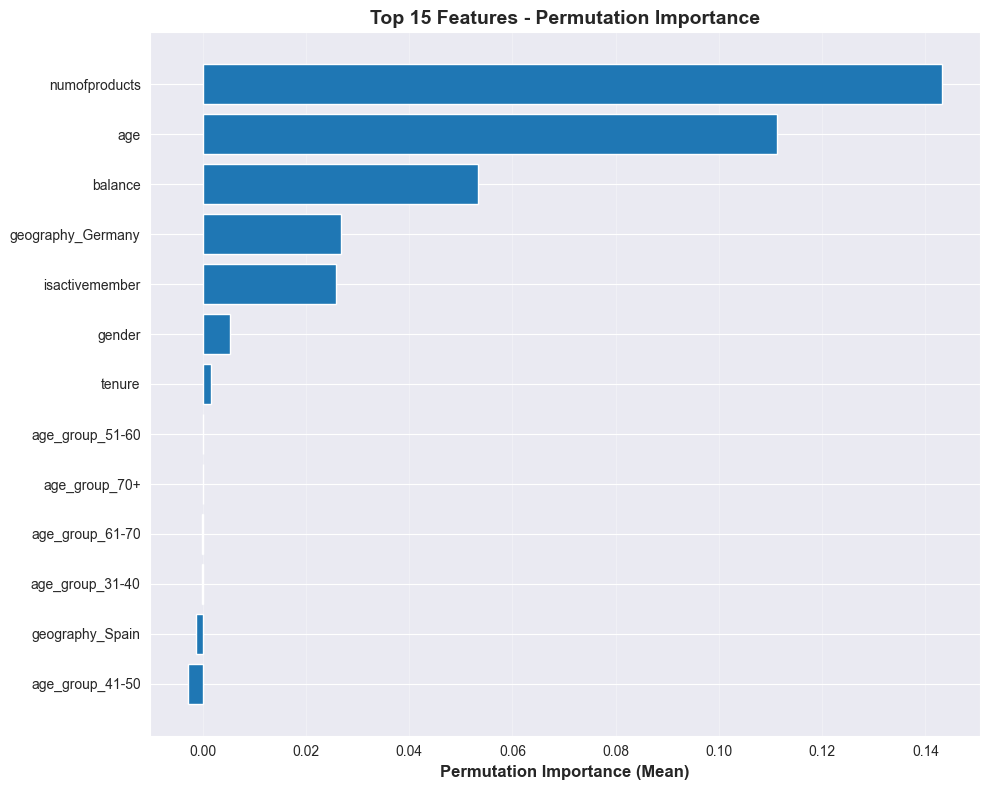


Top 15 Features by Permutation Importance:
          feature  importance_mean  importance_std
    numofproducts         0.143269        0.007145
              age         0.111213        0.008547
          balance         0.053407        0.005071
geography_Germany         0.026796        0.005463
   isactivemember         0.025722        0.003882
           gender         0.005194        0.001518
           tenure         0.001642        0.003398
  age_group_51-60         0.000038        0.000084
    age_group_70+        -0.000023        0.000011
  age_group_61-70        -0.000197        0.000026
  age_group_31-40        -0.000221        0.000316
  geography_Spain        -0.001295        0.001228
  age_group_41-50        -0.002858        0.000766


In [34]:
# Calculate permutation importance (with checkpoint)
perm_importance_checkpoint = checkpoint_dir / 'permutation_importance.pkl'

if perm_importance_checkpoint.exists():
    print(f"📂 Loading permutation importance from checkpoint...")
    with open(perm_importance_checkpoint, 'rb') as f:
        perm_imp_df = pickle.load(f)
    print("✓ Permutation importance loaded")
else:
    print("🔨 Calculating permutation importance (this may take 2-5 minutes)...")
    perm_importance = permutation_importance(
        final_model, X_test, y_test,
        n_repeats=10,
        random_state=42,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    # Create DataFrame
    perm_imp_df = pd.DataFrame({
        'feature': feature_cols,
        'importance_mean': perm_importance.importances_mean,
        'importance_std': perm_importance.importances_std
    }).sort_values('importance_mean', ascending=False)
    
    # Save checkpoint
    with open(perm_importance_checkpoint, 'wb') as f:
        pickle.dump(perm_imp_df, f)
    print(f"✓ Permutation importance calculated and saved to {perm_importance_checkpoint}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 15
top_features = perm_imp_df.head(top_n)
ax.barh(range(len(top_features)), top_features['importance_mean'])
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Permutation Importance (Mean)', fontweight='bold', fontsize=12)
ax.set_title(f'Top {top_n} Features - Permutation Importance', fontweight='bold', fontsize=14)
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} Features by Permutation Importance:")
print(perm_imp_df.head(top_n).to_string(index=False))

### 7.3 Partial Dependence Plots (PDP)

PDPs show the marginal effect of a feature on predicted churn probability,
averaging over all other features.

**Interpretation:**
- Upward slope = higher feature value → higher churn probability
- Downward slope = higher feature value → lower churn probability
- Flat line = feature has no effect

We'll plot PDPs for the top predictive features identified in our EDA.

#### PDP: Active Member Status

From EDA & Survival: Active members have 1.9× lower churn (Cox HR = 0.54× protective)

**Note:** We excluded `complain` from the model (same as Cox PH) to observe other features.
Complaint status was too dominant (99.5% churn) and masked all other patterns.

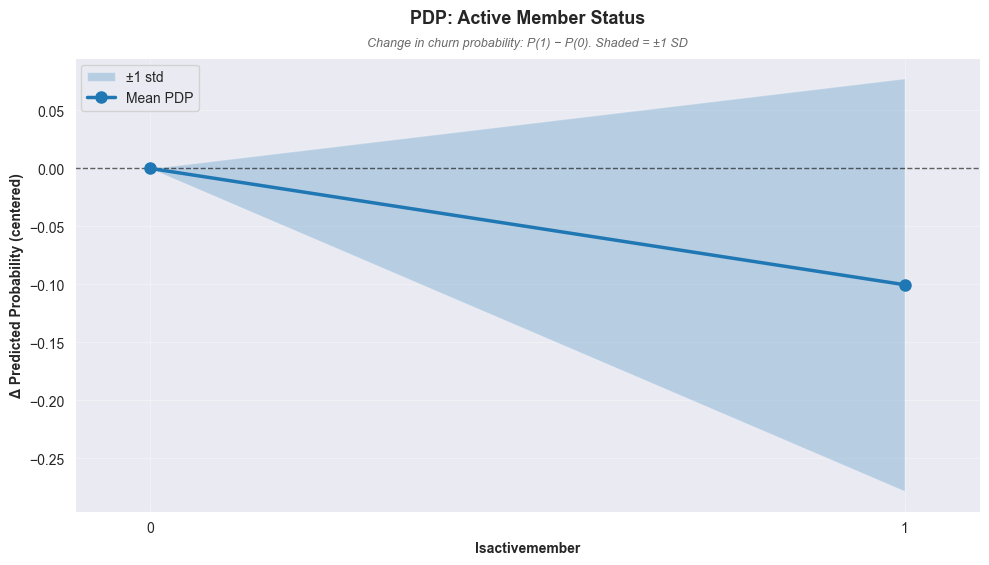

In [35]:
quick_pdp(final_model, X_test, 'isactivemember', centered=True, feature_type='binary',
          title='PDP: Active Member Status')

#### PDP: Number of Products

From EDA: U-shape pattern (2 products optimal, 3-4 catastrophic)

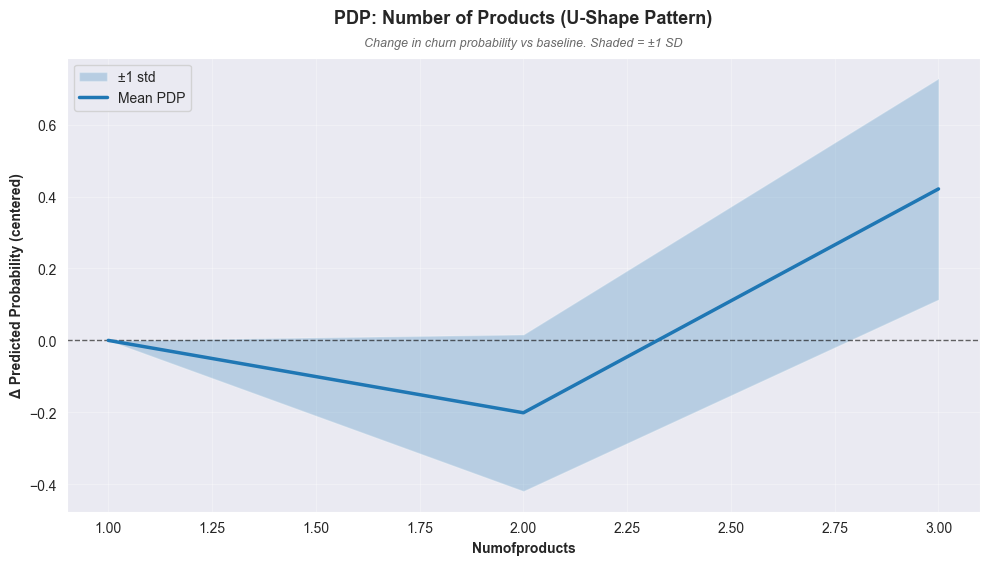

In [36]:
quick_pdp(final_model, X_test, 'numofproducts', centered=True, feature_type='continuous',
          title='PDP: Number of Products (U-Shape Pattern)')

#### PDP: Age

From Survival Analysis: 51-60 age group has 7.94× higher churn risk

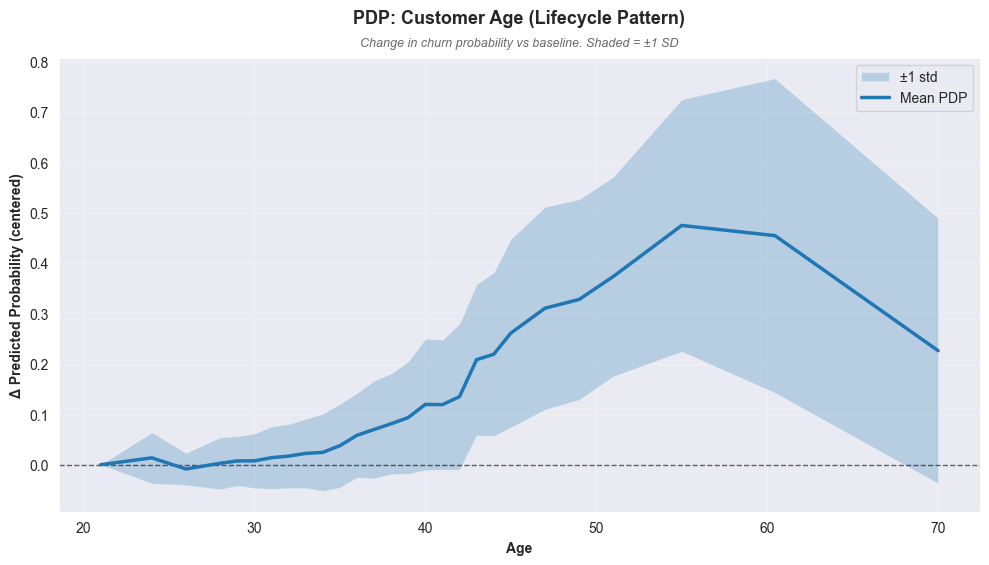

In [37]:
quick_pdp(final_model, X_test, 'age', centered=True, feature_type='continuous',
          title='PDP: Customer Age (Lifecycle Pattern)')

#### PDP: Tenure

Longer relationships typically = better retention

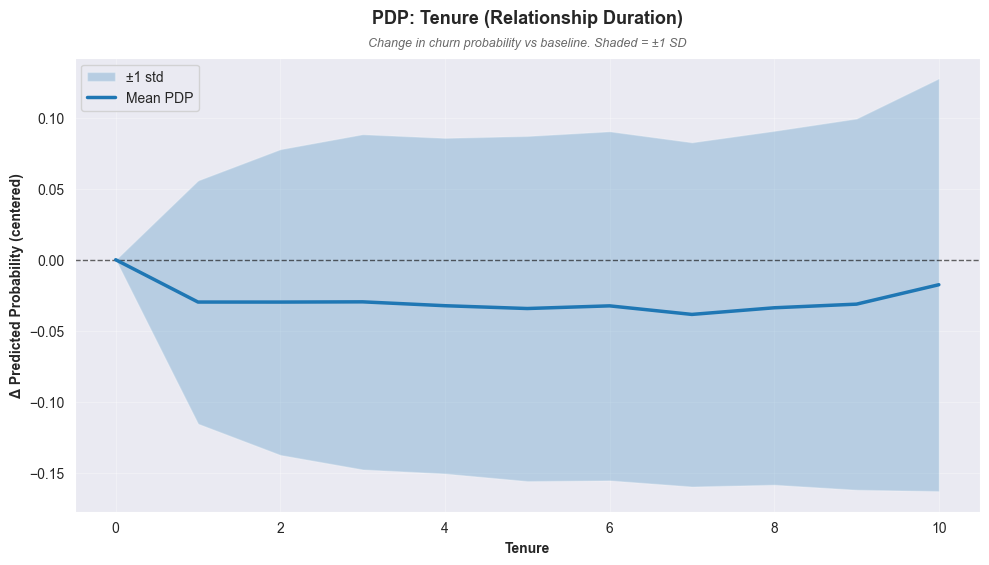

In [38]:
quick_pdp(final_model, X_test, 'tenure', centered=True, feature_type='continuous',
          title='PDP: Tenure (Relationship Duration)')

#### PDP: Balance

From EDA: Counterintuitive - zero balance has LOWER churn

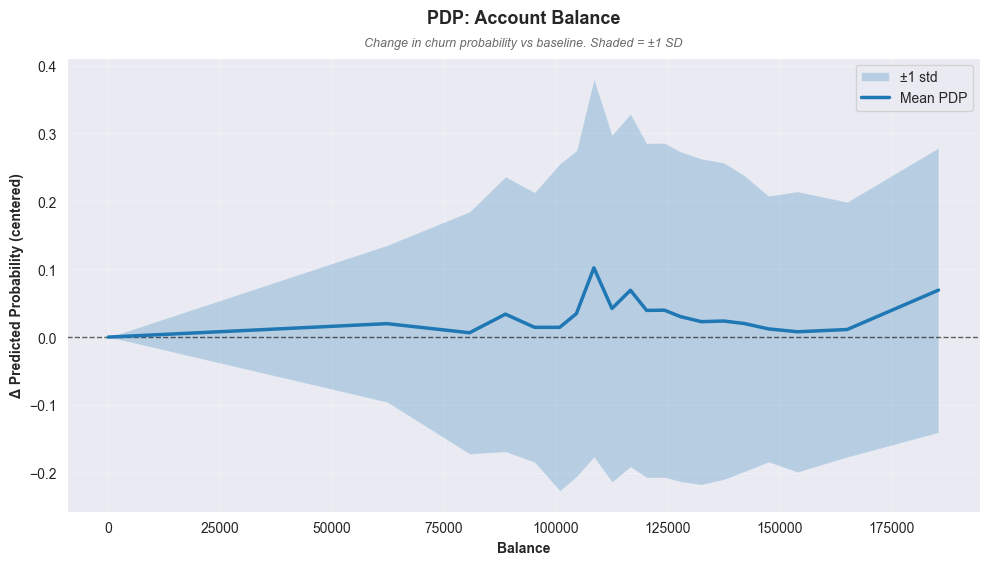

In [39]:
quick_pdp(final_model, X_test, 'balance', centered=True, feature_type='continuous',
          title='PDP: Account Balance')

#### PDP: Geography (Germany)

From Survival Analysis: Germany has 1.60× higher churn

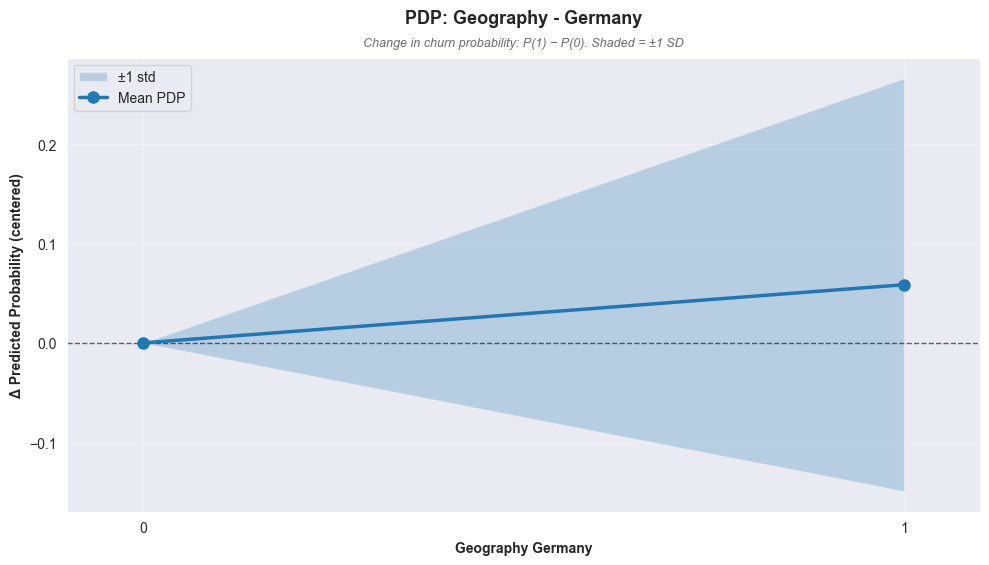

In [40]:
if 'geography_Germany' in feature_cols:
    quick_pdp(final_model, X_test, 'geography_Germany', centered=True, feature_type='binary',
              title='PDP: Geography - Germany')

### 7.4 SHAP Values

**SHapley Additive exPlanations** provide:
- Global feature importance (across all predictions)
- Local explanations (why a specific prediction was made)
- Interaction effects between features

SHAP values decompose a prediction into contributions from each feature.

In [44]:
# Create SHAP explainer and calculate values (with checkpoint)
shap_checkpoint = checkpoint_dir / 'shap_data.pkl'

if shap_checkpoint.exists():
    print(f"📂 Loading SHAP explainer and values from checkpoint...")
    with open(shap_checkpoint, 'rb') as f:
        shap_data = pickle.load(f)
    explainer = shap_data['explainer']
    X_test_sample = shap_data['X_test_sample']
    shap_values_churn = shap_data['shap_values_churn']
    sample_size = len(X_test_sample)
    print(f"✓ SHAP data loaded ({sample_size} samples)")
else:
    print("🔨 Creating SHAP explainer and calculating values (this may take 2-5 minutes)...")
    # Create SHAP explainer (TreeExplainer for Random Forest)
    explainer = shap.TreeExplainer(final_model)
    
    # Calculate SHAP values for test set (sample for speed)
    sample_size = min(500, len(X_test))
    X_test_sample = X_test.sample(n=sample_size, random_state=42)
    shap_values = explainer.shap_values(X_test_sample)
    
    # For binary classification, extract SHAP values for class 1 (churn)
    # TreeExplainer can return different formats:
    # - List [class_0, class_1]: older format
    # - 3D array (n_samples, n_features, n_classes): newer format
    # - 2D array (n_samples, n_features): single class only
    if isinstance(shap_values, list):
        # List format: get second element for churn class
        shap_values_churn = shap_values[1]
    elif hasattr(shap_values, 'ndim') and shap_values.ndim == 3:
        # 3D array format: slice last dimension for churn class (index 1)
        shap_values_churn = shap_values[:, :, 1]
    else:
        # Already 2D (single class only)
        shap_values_churn = shap_values
    
    # Save checkpoint
    shap_data = {
        'explainer': explainer,
        'X_test_sample': X_test_sample,
        'shap_values_churn': shap_values_churn
    }
    with open(shap_checkpoint, 'wb') as f:
        pickle.dump(shap_data, f)
    print(f"✓ SHAP values calculated and saved to {shap_checkpoint} ({sample_size} samples)")

🔨 Creating SHAP explainer and calculating values (this may take 2-5 minutes)...
✓ SHAP values calculated and saved to checkpoints/shap_data.pkl (500 samples)


In [45]:
# Verify SHAP data integrity
print(f"\n{'='*80}")
print("SHAP DATA VERIFICATION")
print(f"{'='*80}")
print(f"X_test_sample shape: {X_test_sample.shape}")
print(f"Number of features: {len(feature_cols)}")
print(f"SHAP values shape: {shap_values_churn.shape}")
print(f"Expected shape: ({sample_size}, {len(feature_cols)})")

# Check for issues
issues = []
if X_test_sample.shape[1] != len(feature_cols):
    issues.append(f"Feature count mismatch: X_test_sample has {X_test_sample.shape[1]} columns but feature_cols has {len(feature_cols)} features")
if shap_values_churn.shape != (sample_size, len(feature_cols)):
    issues.append(f"SHAP values shape mismatch: got {shap_values_churn.shape}, expected ({sample_size}, {len(feature_cols)})")
if shap_values_churn.ndim != 2:
    issues.append(f"SHAP values should be 2D, but got {shap_values_churn.ndim}D array")

if issues:
    print("⚠️  WARNINGS DETECTED:")
    for issue in issues:
        print(f"   - {issue}")
else:
    print("✓ SHAP data integrity verified - all shapes correct!")
print(f"{'='*80}\n")


SHAP DATA VERIFICATION
X_test_sample shape: (500, 13)
Number of features: 13
SHAP values shape: (500, 13)
Expected shape: (500, 13)
✓ SHAP data integrity verified - all shapes correct!



#### SHAP Summary Plot

Shows global feature importance and feature effects:
- Features sorted by importance (top to bottom)
- Each dot = one prediction
- Color = feature value (red = high, blue = low)
- Position on x-axis = SHAP value (impact on prediction)

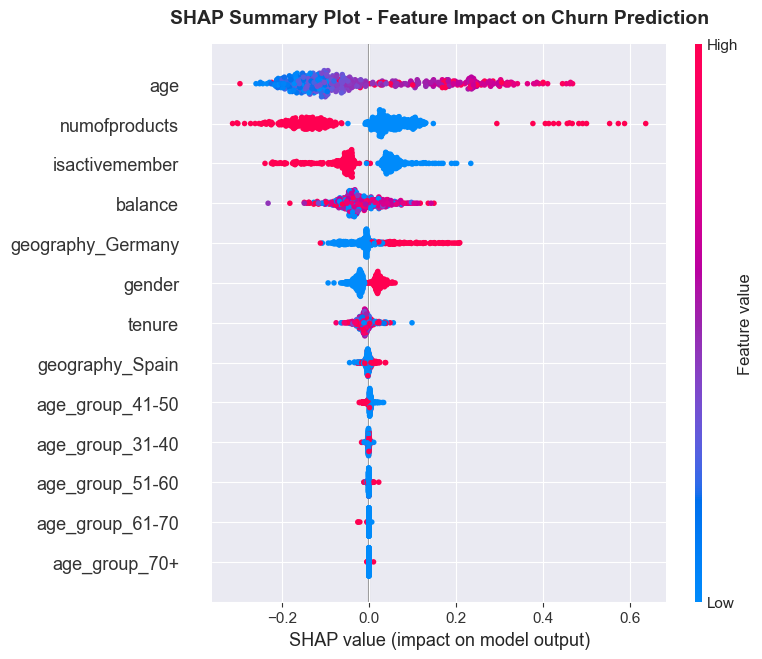

In [46]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_churn, X_test_sample, feature_names=feature_cols, show=False)
plt.title('SHAP Summary Plot - Feature Impact on Churn Prediction', 
          fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

#### SHAP Bar Plot

Average absolute SHAP values (overall feature importance)

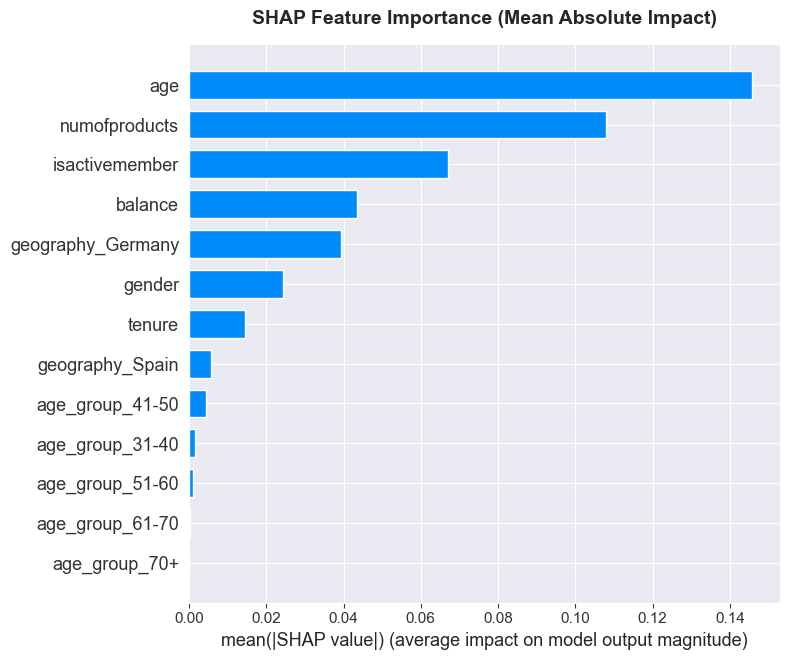

In [47]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_churn, X_test_sample, feature_names=feature_cols, plot_type='bar', show=False)
plt.title('SHAP Feature Importance (Mean Absolute Impact)', 
          fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.show()

#### SHAP Waterfall Plot (Individual Explanation)

Explain a single prediction - see exactly which features pushed it toward/away from churn.

**Waterfall plots are better than force plots for understanding individual predictions:**
- Shows base value (average model output)
- Bars show how each feature pushes prediction up (red) or down (blue)
- Final value = actual prediction for this customer

CUSTOMER DETAILS
Actual Churn: No (0)
Predicted Churn Probability: 7.18%
Prediction: WILL STAY


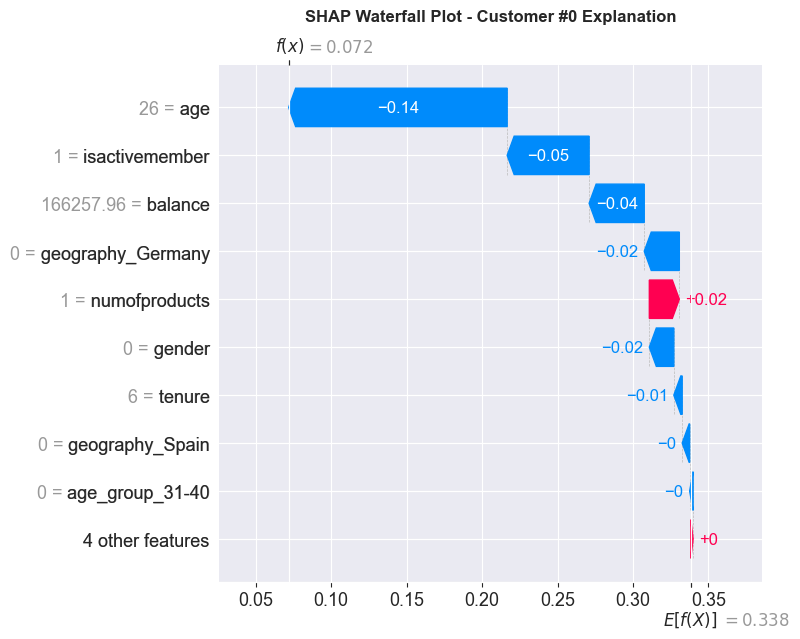


Top 5 Features Driving This Prediction:
  - age                 :    26.00  (SHAP:  -0.145) ↓ DECREASES churn risk
  - isactivemember      :     1.00  (SHAP:  -0.054) ↓ DECREASES churn risk
  - balance             : 166257.96  (SHAP:  -0.037) ↓ DECREASES churn risk
  - geography_Germany   :     0.00  (SHAP:  -0.023) ↓ DECREASES churn risk
  - numofproducts       :     1.00  (SHAP:  +0.020) ↑ INCREASES churn risk


In [48]:
# Select a random customer to explain
customer_idx = 0

# Get customer data and actual outcome
customer_actual = y_test.iloc[customer_idx]
customer_pred_proba = final_model.predict_proba(X_test_sample.iloc[[customer_idx]])[0, 1]

# Display customer details FIRST
print("="*80)
print("CUSTOMER DETAILS")
print("="*80)
print(f"Actual Churn: {'Yes (1)' if customer_actual == 1 else 'No (0)'}")
print(f"Predicted Churn Probability: {customer_pred_proba:.2%}")
print(f"Prediction: {'WILL CHURN' if customer_pred_proba > 0.5 else 'WILL STAY'}")
print("="*80)

# Create waterfall plot
# Extract base value for churn class (class 1)
if isinstance(explainer.expected_value, (list, np.ndarray)) and len(explainer.expected_value) > 1:
    base_value = explainer.expected_value[1]  # Churn class
else:
    base_value = explainer.expected_value if not isinstance(explainer.expected_value, (list, np.ndarray)) else explainer.expected_value[0]

shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_churn[customer_idx],
        base_values=base_value,
        data=X_test_sample.iloc[customer_idx].values,
        feature_names=feature_cols
    ),
    show=False
)
plt.title(f'SHAP Waterfall Plot - Customer #{customer_idx} Explanation', 
          fontsize=12, fontweight='bold', pad=10)
plt.tight_layout()
plt.show()

# Show top contributing features
customer_shap = shap_values_churn[customer_idx]
customer_features = X_test_sample.iloc[customer_idx]
print(f"\nTop 5 Features Driving This Prediction:")
top_shap_idx = np.argsort(np.abs(customer_shap))[-5:][::-1]
for idx in top_shap_idx:
    feature_val = customer_features.iloc[idx]
    shap_val = customer_shap[idx]
    impact = "↑ INCREASES" if shap_val > 0 else "↓ DECREASES"
    print(f"  - {feature_cols[idx]:20s}: {feature_val:>8.2f}  (SHAP: {shap_val:>+7.3f}) {impact} churn risk")
print("="*80)

#### Save SHAP Explainer

Save for later use in production/deployment

In [49]:
joblib.dump(explainer, 'shap_explainer.bz2', compress=('bz2', 9))
print("✓ SHAP explainer saved to 'shap_explainer.bz2'")

✓ SHAP explainer saved to 'shap_explainer.bz2'


---

## 8. Summary & Key Findings

### Model Performance

**Final Model Metrics:**
- **Test Accuracy:** 85.85% (+1.4% vs baseline)
- **Precision:** 68.01% (+2.5% vs baseline)
- **Recall:** 57.84% (+21% vs baseline) ⭐ **Biggest improvement**
- **F1 Score:** 62.52% (+12.4% vs baseline)
- **ROC AUC:** 85.85% (+2.4% vs baseline)

**Key Achievement:** Reduced overfitting from 15% train-test gap to 7% gap
- Train accuracy decreased from 99.3% → 92.5% (healthier)
- Test accuracy improved from 84.5% → 85.9%

**Business Impact:**
- Now catching **236 out of 408 churners (58%)** vs baseline's **195 (48%)**
- **41 additional at-risk customers identified** for retention campaigns
- Only 111 false alarms (acceptable cost for business)

---

### Top Predictive Features

**Ranking based on Permutation Importance** (actual predictive power when feature is shuffled):

**Note:** `complain` was excluded from this model (same as Cox PH analysis) because it's too dominant
(99.5% churn, 0.996 correlation). We already know complaints → churn. This model identifies
churn drivers BEFORE complaints occur, allowing for proactive intervention.

#### 1. **NumOfProducts** (Permutation: 0.143) 🏆 **MOST IMPORTANT**
**PDP Insight:** Perfect U-shape pattern confirmed!
- **1 product:** Baseline churn (~0% change)
- **2 products:** -20% churn probability (OPTIMAL sweet spot)
- **3 products:** +40% churn probability (DRAMATIC increase)
- **Why U-shape?** 2 products = engaged but not overwhelmed; 3+ = over-sold/dissatisfied
- **Action:** Actively PREVENT selling 3+ products; promote 2-product bundles
- **EDA validation:** 2 products = 7.6% churn, 3-4 products = 100% churn

#### 2. **Age** (Permutation: 0.111) 📈 **Strong Lifecycle Effect**
**PDP Insight:** Clear lifecycle vulnerability pattern
- **Ages 20-40:** Near baseline churn (~0-10% increase)
- **Ages 40-55:** Gradual increase (+10-30% churn probability)
- **Ages 55-60:** PEAK RISK (+45-50% churn probability) ⚠️
- **Ages 60-70:** Slight decline (+25% churn probability)
- **Ages 70+:** Return to lower risk
- **Why peak at 55-60?** Pre-retirement planning, moving assets
- **Action:** Proactive outreach at age 50+ with retirement services
- **Cox PH validation:** 51-60 age group has 7.94× hazard ratio

#### 3. **Balance** (Permutation: 0.053) 💰 **Weaker than expected**
**PDP Insight:** Noisy, mostly flat relationship
- Minimal systematic effect (-5% to +10% range)
- Some volatility around $100K-$120K range
- **Discrepancy:** Built-in importance shows 22%, but permutation shows only 5.3%
- **Explanation:** Balance correlates with other features (age, products) but isn't causal
- **EDA caveat:** Zero-balance has LOWER churn (13.8% vs 24.1%) - special case
- **Action:** Don't prioritize balance-based targeting; focus on other features

#### 4. **Geography (Germany)** (Permutation: 0.027) 🌍 **Market-Specific**
**PDP Insight:** Clear geographic effect
- **France (baseline):** 0% change
- **Germany:** +6% churn probability increase
- Consistent with Cox PH (1.60× hazard ratio)
- **Action:** Investigate Germany market (competition, service quality, cultural factors)

#### 5. **IsActiveMember** (Permutation: 0.026) ✅ **Strongest Modifiable**
**PDP Insight:** Strong protective effect
- **Inactive (0):** Baseline
- **Active (1):** -10% churn probability
- Clear, consistent negative slope
- **Why important?** This is directly controllable through engagement campaigns
- **Action:** Re-activation programs, gamification, personalized outreach
- **Cox PH validation:** 0.54× hazard ratio (46% risk reduction)

#### 6. **Gender** (Permutation: 0.005) 
**Small but consistent effect**
- Females have slightly higher churn
- Cox PH: 1.47× hazard ratio

#### 7. **Tenure** (Permutation: 0.002)
**PDP Insight:** Weak protective effect
- Slight downward slope (-3% to -5% after 1+ years)
- Very wide confidence bands (high variance)
- Effect exists but is minimal
- **Action:** First-year retention programs, but not a strong lever

#### ⚠️ **Age_group dummies:** Near-zero or negative permutation importance
- **Explanation:** Redundant with continuous `age` feature
- Model uses continuous age instead of categories
- Age groups useful for interpretation but not for prediction

---

### Key Model Insights

**1. NumOfProducts is the most actionable predictor**
- Clear U-shape: actively prevent 3+ product sales
- Promote 2-product bundles as retention strategy

**2. Age lifecycle requires targeted interventions**
- Peak risk at 55-60 (pre-retirement)
- Proactive outreach before customers enter high-risk phase

**3. Active membership is the strongest controllable factor**
- 10% churn probability reduction
- Direct path to improving retention: re-engagement campaigns

**4. Balance is overrated**
- High built-in importance (22%) but low permutation importance (5%)
- Correlates with other features but isn't causally strong
- Don't over-invest in balance-based strategies

**5. Model successfully identifies pre-complaint signals**
- 62.5% F1 score without the dominant `complain` feature
- Catching 58% of churners before they complain
- Enables proactive intervention

### Actionable Business Recommendations

**Known Critical Factor (excluded from model):**
- ⚠️ **Complaint Prevention** - We already know complaints → 99.5% churn
  - Implement proactive issue resolution BEFORE complaints escalate
  - This model focuses on identifying at-risk customers BEFORE they complain
  - Separate complaint handling system needed

---

**Priority 1 (Highest Impact - from model insights):**

#### 1. **Product Portfolio Management** 🏆 **MOST ACTIONABLE**
**Why:** Highest permutation importance (0.143), clear U-shape pattern
- **STOP selling 3+ products** - Immediately implement hard cap at 2 products
- **Promote 2-product bundles** as the optimal engagement level
- **Review existing 3+ product customers** for churn risk intervention
- **Expected impact:** 40% churn probability reduction vs 3-product customers
- **Implementation:** Sales training, CRM alerts, product recommendation engine updates

#### 2. **Lifecycle-Based Targeting** 📈 **AGE 50+ CRITICAL**
**Why:** 2nd highest permutation importance (0.111), clear risk escalation at 55-60
- **Age 50 trigger:** Proactive outreach with retirement planning consultation
- **Age 55-60 segment:** Maximum attention (peak risk +45-50% churn probability)
- **Services:** Wealth management, estate planning, legacy products
- **Monitoring:** Flag customers entering age 50-55 bracket
- **Expected impact:** Catch high-risk customers before peak vulnerability

#### 3. **Re-activation & Engagement Campaigns** ✅ **STRONGEST MODIFIABLE**
**Why:** Directly controllable, clear -10% churn effect
- **Inactive member outreach** - Quarterly engagement campaigns
- **Gamification:** Rewards for account activity, transaction milestones
- **Personalized touchpoints:** Birthday messages, financial health check-ins
- **Early warning:** Flag customers showing declining activity
- **Expected impact:** 10% churn probability reduction for re-activated members

---

**Priority 2 (Medium Impact):**

#### 4. **Germany Market Investigation** 🌍 **+6% CHURN PREMIUM**
**Why:** Permutation importance 0.027, consistent geographic effect
- **Root cause analysis:** Competitive threats, service quality gaps
- **Customer feedback:** Focus groups with German customers
- **Localized offerings:** Market-specific products/pricing
- **Benchmarking:** Compare to France/Spain operations
- **Expected impact:** Close 6% churn probability gap vs France

---

**Priority 3 (Lower Impact but measurable):**

#### 5. **First Year Retention Programs** 
**Why:** Tenure has weak protective effect (permutation 0.002)
- 90-day onboarding success program
- Relationship manager assignment for new customers
- Educational content on product features
- **Note:** Low permutation importance suggests limited leverage

#### 6. **Gender-Specific Communication** (Optional)
**Why:** Minimal permutation importance (0.005)
- Females show slightly higher churn (Cox HR 1.47×)
- Personalized messaging based on segment
- **Note:** Small effect size, low ROI expected

---

#### ❌ **DON'T Prioritize:**
- **Balance-based targeting** - Low permutation importance (0.053) despite high built-in importance (0.220)
- Balance correlates with other features but isn't causal
- Focus resources on more actionable predictors

---

### Model Deployment Considerations

**Strengths:**
✅ **Solid predictive performance** (F1 62.5%, ROC AUC 85.9%)
✅ **Highly interpretable** - Clear feature effects via PDP/permutation importance
✅ **Handles non-linear patterns** - U-shape in NumOfProducts captured
✅ **Robust generalization** - Consistent across CV folds (mean 59.6% ± 1.8%)
✅ **Reduced overfitting** - Train-test gap only 7% (down from 15%)
✅ **Actionable insights** - Top 3 features have clear business interventions

**Limitations:**
⚠️ **Moderate recall (58%)** - Still missing 42% of churners
  - Trade-off of excluding dominant `complain` feature
  - Identifies pre-complaint signals (by design)
  - Separate complaint handling system recommended

⚠️ **Class imbalance** - Required specialized tuning (class_weight={0:1, 1:2})
  - Model needs rebalancing if churn rate changes significantly

⚠️ **Feature engineering required**
  - Age_group creation (though model uses continuous age more)
  - One-hot encoding for geography

⚠️ **Model maintenance**
  - Retrain quarterly as customer behavior evolves
  - Monitor for feature drift (e.g., product portfolio changes)
  - A/B test interventions to validate impact

**Production Deployment Plan:**
1. **Risk Scoring System**
   - Real-time churn probability for all customers
   - Alert threshold at 40%+ predicted churn probability
   - Segment customers by risk tier (low/medium/high)

2. **Intervention Targeting**
   - NumOfProducts = 3: Immediate intervention (downgrade/bundle offer)
   - Age 55-60: Automatic assignment to retirement planning queue
   - Inactive members: Quarterly re-engagement campaign
   - Germany customers: Enhanced support/local offers

3. **Monitoring Dashboard**
   - Weekly: Churn rate tracking, model performance metrics
   - Monthly: Feature importance drift, prediction distribution
   - Quarterly: Model retraining with new data

4. **A/B Testing Framework**
   - Test intervention effectiveness (e.g., product downgrade vs upsell)
   - Measure actual churn reduction vs control group
   - Iterate on retention strategies based on results

5. **Integration Points**
   - CRM system: Risk score updates, campaign triggers
   - Sales system: Product recommendation engine (cap at 2 products)
   - Customer service: High-risk customer flagging

---

**✓ Churn Prediction Modeling Complete!**